## Char-RNN 을 사용해 셰익스피어 문체 생성하기

### 훈련 데이터셋 만들기

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
shakespeare_url = 'https://homl.info/shakespeare'
filepath = keras.utils.get_file('shakespeare.txt',shakespeare_url)
with open(filepath) as f:
    shakespeare__text = f.read()

# 셰익스피어 작품을 모두 다운로드

1122304/1115394 [==============================] - 0s 0us/step


In [3]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) # 단어 수준 인코딩 대신 글자 수준 인코딩을 만든다
tokenizer.fit_on_texts(shakespeare__text)
# 모든 글자를 정수로 인코딩

# 텍스트에서 사용되는 모든 글자를 찾아 각기 다른 글자 ID에 매핑한다.
# (이 ID는 1부터 시작해 고유한 글자 개수까지 만들어진다.)

In [4]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [5]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [6]:
max_id = len(tokenizer.word_index) # 고유 글자 갯수
print(max_id)
dataset_size = tokenizer.document_count # 전체 글자 갯수
print(dataset_size)

39
1115394


In [7]:
import numpy as np

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare__text])) - 1
# 각 글자의 ID는 1~39로 되어있기 때문에 1을 뺀다.

In [8]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [9]:
n_steps =100
window_length = n_steps + 1
dataset = dataset.window(window_length , shift = 1, drop_remainder=True)
# shift = 1 => 0 ~ 100 / 1~ 101 ...
# drop_remainder 가 False 라면 => 100개 / 99개 / 98개 ...

# window() 메서드를 사용해 긴 시퀀스를 작은 많은 텍스트 윈도로 변환한다.


In [10]:
dataset = dataset.flat_map(lambda window : window.batch(window_length))
# 중첩 데이터셋을 플랫 데이터셋으로 변환하는 flat_map()메서드를 호출.
# 평평하게 만들기 전에 각 데이터셋에 적용할 변환함수를 파라미터로 받는다.

In [11]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows : (windows[:, :-1] , windows[:, 1:]))
# 입력과 타겟을 분리

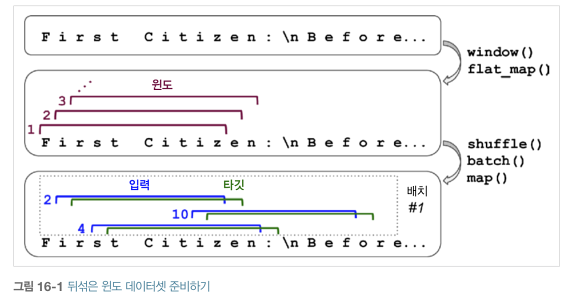

In [12]:
dataset = dataset.map(
    lambda X_batch, Y_batch : (tf.one_hot(X_batch, depth = max_id), Y_batch))

In [13]:
dataset= dataset.prefetch(1)

### Char-RNN 모델 만들고 훈련하기

In [15]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
    # 텍스트에 있는 고유 글자수가 39개 이므로 이 층은 39개의 유닛을 가져야 한다.
    # 타임 스텝에서 출력 확률의 합을 1로 하기 위해서 소프트맥스 함수를 적용한다.
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=1)

31370/31370 [==============================] - 337s 11ms/step - loss: 1.7230


### Char_RNN 모델 사용하기

In [16]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [20]:
X_new = preprocess(['how are yo'])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred +1)[0][-1]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'u'

### 가짜 셰익스피어 텍스트를 생성하기

In [24]:
def next_char(text, temperature =1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    # 온도가 0에 가까울 수록 높은 확률을 가진 글자를 선택한다.
    char_id = tf.random.categorical(rescaled_logits , num_samples=1) + 1
    # 모델이 추정한 확률을 기반으로 다음 글자를 무작위로 선택한다.
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [25]:
def complete_text(text, n_chars = 50 , temperature = 1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [26]:
print(complete_text('t', temperature=0.2))

the curst and signior gremio.

gremio:
o the mottor


In [27]:
print(complete_text('w', temperature=1))

ws:
if you heve with mace he curst as, 'binner, bel


In [28]:
print(complete_text('w', temperature=2))

wirs, no? kate'romet. ope, asly.'we,,ilep,s
ayy.fti


### 상태가 있는 RNN

In [29]:
# 마지막 상태를 다음 훈련 배치의 초기 상태로 사용한다.

dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window : window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows : (windows[:, : -1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch : (tf.one_hot(X_batch, depth = max_id), Y_batch)
)
dataset = dataset.prefetch(1)

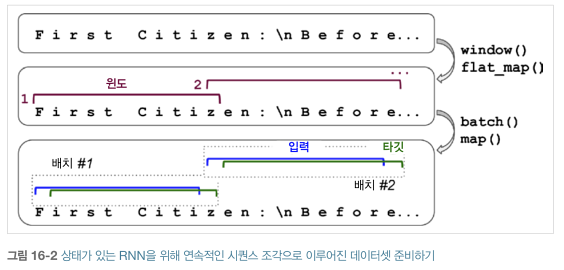

In [30]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [31]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True, # 마지막 상태 전달
                     dropout=0.2, #recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
                     #배치에 있는 입력 시퀀스의 상태를 보존하기 위해 input shape 지정
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [32]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 5s 12ms/step - loss: 2.9086
Epoch 2/50
313/313 [==============================] - 4s 11ms/step - loss: 2.2922
Epoch 3/50
313/313 [==============================] - 4s 11ms/step - loss: 2.1362
Epoch 4/50
313/313 [==============================] - 4s 11ms/step - loss: 2.0505
Epoch 5/50
313/313 [==============================] - 4s 11ms/step - loss: 1.9937
Epoch 6/50
313/313 [==============================] - 4s 11ms/step - loss: 1.9562
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 1.9260
Epoch 8/50
313/313 [==============================] - 4s 11ms/step - loss: 1.9032
Epoch 9/50
313/313 [==============================] - 4s 11ms/step - loss: 1.8824
Epoch 10/50
313/313 [==============================] - 4s 11ms/step - loss: 1.8656
Epoch 11/50
313/313 [==============================] - 4s 11ms/step - loss: 1.8539
Epoch 12/50
313/313 [==============================] - 4s 11ms/step - loss: 1.8436
Epoch 13/50
3

## 감성 분석

In [35]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.imdb.load_data()
X_train[0][:10]
# X_train 은 리뷰들의 리스트이다.
# 각 리뷰는 넘파이 정수 배열로 표현된다.
# (각 정수는 하나의 단어를 나타낸다.)

# 구두점을 모두 제거하고, 단어는 소문자로 변환한 다음 공백으로 나누어
## 빈도에 따라 인덱스를 붙였다. ==> 낮은 정수가 자주 등장하는 단어에 해당한다.

# 정수 0, 1, 2는 각각 패딩토큰 , SOS 토큰, 알 수없는 단어를 의미한다.

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [36]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info = True)

In [39]:
train_size = info.splits['train'].num_examples
test_size = info.splits["test"].num_examples

In [41]:
print(train_size)
print(test_size)

25000
25000


In [43]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch,0 , 300)
    # 처음 300글자만 남긴다. => 훈련 속도를 높일 수 있다.
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    # <br /> 을 공백으로 바꾼다.
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z]", b" ")
    # 문자가 아닌 다른 모든 문자를 공백으로 바꾼다.
    X_batch = tf.strings.split(X_batch)
    # 리뷰를 공백으로 나눈다.
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [44]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in datasets['train'].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [45]:
vocabulary.most_common()[:3]

[(b'<pad>', 224494), (b'the', 61156), (b'a', 38569)]

In [47]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[: vocab_size]
]

In [49]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [50]:
table.lookup(tf.constant([b'this movie was faaaaaaaaaantasitc'.split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   10,    12,    13, 10977]])>

In [54]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets['train'].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [55]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
    # 리뷰가 영화에 대한 긍정적인 감정을 표현하는지에 대한 추정 확률
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 31s 31ms/step - loss: 0.6099 - accuracy: 0.6358
Epoch 2/5
781/781 [==============================] - 24s 31ms/step - loss: 0.3739 - accuracy: 0.8366
Epoch 3/5
781/781 [==============================] - 24s 31ms/step - loss: 0.2121 - accuracy: 0.9187
Epoch 4/5
781/781 [==============================] - 24s 31ms/step - loss: 0.1477 - accuracy: 0.9475
Epoch 5/5
781/781 [==============================] - 24s 31ms/step - loss: 0.1001 - accuracy: 0.9634


### 마스킹

In [ ]:
# 무시할 토큰을 알고 있다면 해당 토큰을 무시하도록 모델에게 알려주어
# 실제 의미가 있는 데이터에 집중할 수 있게 만든다.
# => Embedding 층이 keras.backend.not_equal(inputs, 0) 와 같은 마스크 텐서를 만든다.
# => 이 텐서는 입력과 크기가 같은 boolean 텐서이다.
# => ID가 0인 위치는 False 이고, 나머지는 True 이다.

# 이 마스크 텐서는 모델에 의해 이어지는 모든 층에 타임 스탭 차원이 유지되는 한 자동으로 전파된다.

In [56]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 30s 31ms/step - loss: 0.6038 - accuracy: 0.6393
Epoch 2/5
781/781 [==============================] - 24s 31ms/step - loss: 0.3726 - accuracy: 0.8383
Epoch 3/5
781/781 [==============================] - 24s 31ms/step - loss: 0.2102 - accuracy: 0.9202
Epoch 4/5
781/781 [==============================] - 24s 31ms/step - loss: 0.1363 - accuracy: 0.9524
Epoch 5/5
781/781 [==============================] - 24s 31ms/step - loss: 0.1082 - accuracy: 0.9619


### 사전훈련된 임베딩 재사용하기

In [58]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1',
                   dtype=tf.string, input_shape = [], output_shape=[50]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 5s 5ms/step - loss: 0.5844 - accuracy: 0.6944
Epoch 2/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5209 - accuracy: 0.7433
Epoch 3/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5146 - accuracy: 0.7462
Epoch 4/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5106 - accuracy: 0.7504
Epoch 5/5
781/781 [==============================] - 4s 5ms/step - loss: 0.5073 - accuracy: 0.7517
